# Making an initial condition for MOM5 passive tracers

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:40343 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.36 GB


### 1. Crib data from existing restart file to get correct sized arrays. 
Divide by itself so it is unity everywhere.

In [3]:
ocean_temp_salt_res = '/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/ocean_temp_salt.res.nc'
salt = xr.open_dataset(ocean_temp_salt_res).salt
ross = salt/salt  

### 2. Grab an ocean.nc file from somewhere to get mask for active cells

In [26]:
random_file='/scratch/x77/amh157/access-om2/archive/01deg_jra55v13_ryf9091/output800/ocean/ocean.nc'
salt = xr.open_dataset(random_file).salt.isel(time=0)
mask = salt/salt

### 3. Modify numerical values to create passive tracer in surface grid boxes in Ross Sea
Keep values of unity in surface of Ross Sea, zeroes elsewhere. Mask out land.

In [27]:
ross = ross.where((ross.ZT<1)&(ross.GRID_Y_T<-72)&(ross.GRID_X_T>-200)&(ross.GRID_X_T<-165), 0.0)
ross = ross*mask.values
ross.attrs["long_name"] = "Ross Sea passive tracer location"
ross.name = "passive_ross"
ross

<xarray.DataArray 'passive_ross' (time: 1, ZT: 75, GRID_Y_T: 2700, GRID_X_T: 3600)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time      (time) object 0001-01-02 12:00:00
Attributes:
    long_name:  Ross Sea passive tracer location

### 4. Plot

(-80.0, -60.0)

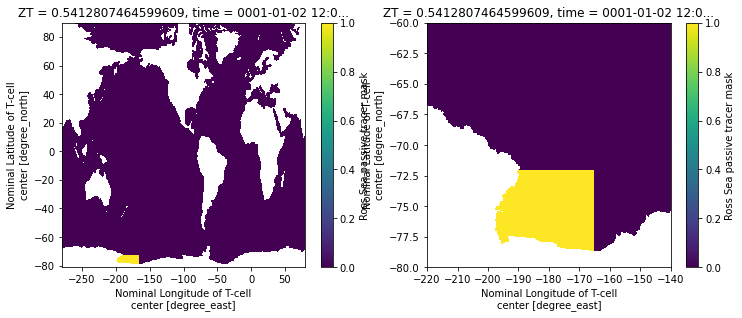

In [31]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
ross.isel(ZT=0).plot()
plt.subplot(122)
ross.isel(ZT=0).plot()
plt.xlim([-220,-140])
plt.ylim([-80, -60])

### 5. Save to netcdf

In [29]:
ross.to_netcdf('ocean_passive.res.nc')

### 6. Turns out you may also need to make a mask for your tracer. 
Not needed if starting from scratch.
Also, the code below didn't actually work for me -- the only way I managed this was to start a new run from scratch, and then collate and save the ocean_passive_masks.res.nc file from that run.
My attempt is below, I don't know why it failed:

### 7. From here you will need to:
* Alter config.yaml to pick up this netcdf file. Something like:

```      
    input:
       	  - /g/data/ik11/inputs/access-om2/input_08022019/mom_01deg
             - /g/data/x77/passive
```         

* Add new entries to the field_table to activate the passive tracers. I used:

```
"tracer_packages","ocean_mod","ocean_passive"
names =	ross
const_init_tracer = .false.
horizontal-advection-scheme = mdppm
vertical-advection-scheme = mdppm
ppm_hlimiter = 3
ppm_vlimiter = 3
restart_file = ocean_passive.res.nc
min_tracer_limit=0.0
/
"namelists","ocean_mod","ocean_passive/ross"
restore	= .true.
/
```

* Add diagnostic output for the tracers to the diag_table

``` 
## Andy's new tests with passive tracers:
"ocean_passive_tracers", 1,  "months", 1, "days", "time",
...
"ocean_model","passive_ross","passive_ross","ocean_passive_tracers","all",.true.,"none",2
```

* The above seems to work if you would like to run a case from scratch. However, I have problems when I want to adad a new tracer to aan existing simulation. Therefore, I ran for 1 month from the WOA initial condition with the above, and collated restart files to give me a new `ocean_passive.res.nc` while also generating a `ocean_passive_masks.res.nc` file. This allowed me to pick up and run from any point in a simulation.